In [1]:
# Imports

import time

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split

import torchvision
import torchvision.transforms as transforms

from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [2]:
# Definitions
INIT_LR = 1e-3
WEIGHT_DECAY = 1e-4
BATCH_SIZE = 64
EPOCHS = 12
TRAIN_SPLIT = 0.75
VAR_SPLIT = 1 - TRAIN_SPLIT
DROPOUT = 0.1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cpu


In [3]:
# Define the network

# Note: Output of each layer is ((input_size + 2*padding - kernel_size) / stride) + 1 (round up)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # First convolutional layer: 3 input channels (RGB), outputs 6 channels, kernel size is 5x5

        # 3 x 32 x 32
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 10)

        self.dropout = nn.Dropout(DROPOUT)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        # Flatten output of the convolutional layers
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [4]:
# Create instance
model = Net()
print(model)

# Random data for testing
random_test = torch.rand((1, 3, 32, 32))

result = model(random_test)
print(result)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=10, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)
tensor([[-0.1261, -0.0923, -0.0719,  0.0672,  0.0615,  0.0176,  0.0189,  0.0555,
         -0.0071,  0.1029]], grad_fn=<AddmmBackward0>)


In [5]:
# Load data

fullTrainingSet = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transforms.ToTensor())

# We'll split our training set into 80% training, 20% validation set

trainingSize = int(0.8 * len(fullTrainingSet))
valSize = len(fullTrainingSet) - trainingSize
trainset, valset = torch.utils.data.random_split(fullTrainingSet, [trainingSize, valSize])

# Load the test set
testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transforms.ToTensor())

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE, shuffle=True)
testloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=False)

trainSteps = len(trainloader.dataset) // BATCH_SIZE
valSteps = len(valloader.dataset) // BATCH_SIZE
testSteps = len(testloader.dataset) // BATCH_SIZE

Files already downloaded and verified
Files already downloaded and verified


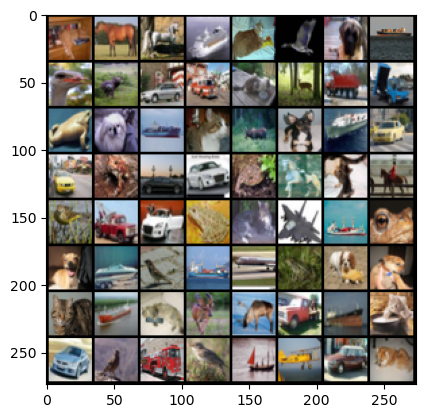

cat   horse horse ship  cat   bird  dog   ship  bird  deer  car   truck cat   deer  truck truck frog  dog   ship  cat   deer  dog   ship  car   car   frog  car   car   frog  horse cat   horse bird  truck car   frog  cat   plane ship  frog  dog   ship  bird  ship  plane frog  dog   dog   cat   ship  cat   deer  deer  truck ship  cat   car   bird  truck bird  ship  plane car   dog  


In [6]:
# Show a batch of images

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(BATCH_SIZE)))


Starting training...
Starting epoch 1/12
Epoch 1 complete
Loss: 1.6794757843017578
Accuracy: 0.383575
Validation loss: 1.4957256317138672
Validation accuracy: 0.4578

Starting epoch 2/12
Epoch 2 complete
Loss: 1.4012378454208374
Accuracy: 0.491975
Validation loss: 1.304015040397644
Validation accuracy: 0.5306

Starting epoch 3/12
Epoch 3 complete
Loss: 1.2882730960845947
Accuracy: 0.537275
Validation loss: 1.2468618154525757
Validation accuracy: 0.5657

Starting epoch 4/12
Epoch 4 complete
Loss: 1.1945747137069702
Accuracy: 0.571325
Validation loss: 1.1794135570526123
Validation accuracy: 0.5934

Starting epoch 5/12
Epoch 5 complete
Loss: 1.1317187547683716
Accuracy: 0.597
Validation loss: 1.1340370178222656
Validation accuracy: 0.6036

Starting epoch 6/12
Epoch 6 complete
Loss: 1.0807727575302124
Accuracy: 0.610025
Validation loss: 1.1105278730392456
Validation accuracy: 0.6077

Starting epoch 7/12
Epoch 7 complete
Loss: 1.033782720565796
Accuracy: 0.6308
Validation loss: 1.0550831556

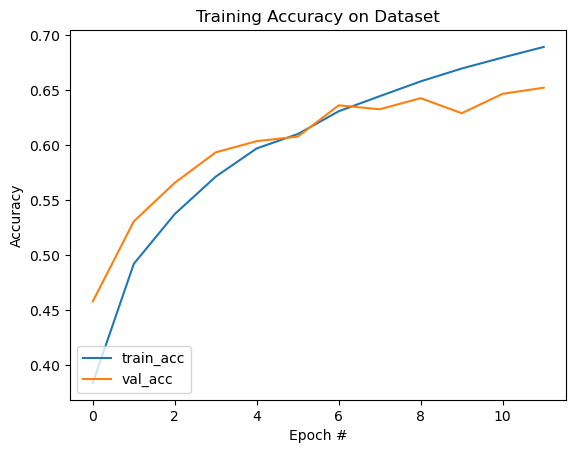

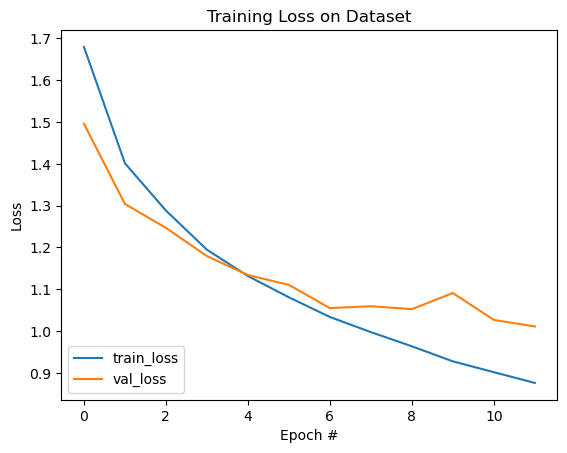

In [7]:
# More parameters

opt = torch.optim.Adam(model.parameters(), lr=INIT_LR, weight_decay=WEIGHT_DECAY)

lossF = nn.CrossEntropyLoss()

H = {
	"train_loss": [],
	"train_acc": [],
	"val_loss": [],
	"val_acc": []
}

print("Starting training...")
startTime = time.time()

for e in range(0, EPOCHS):
    print(f"Starting epoch {e+1}/{EPOCHS}")
    model.train()

    totalTrainLoss = 0
    totalValLoss = 0

    trainCorrect = 0
    valCorrect = 0

    for (x, y) in trainloader:
        (x, y) = (x.to(device), y.to(device))

        pred = model(x)
        loss = lossF(pred, y)

        opt.zero_grad()
        loss.backward()
        opt.step()

        totalTrainLoss += loss
        trainCorrect += (pred.argmax(1) == y).type(torch.float).sum().item()

    # Validation
    with torch.no_grad():
        model.eval()

        for (x, y) in valloader:
            (x, y) = (x.to(device), y.to(device))
            
            pred = model(x)
            
            totalValLoss += lossF(pred, y)
            valCorrect += (pred.argmax(1) == y).type(torch.float).sum().item()

    avgTrainLoss = totalTrainLoss / trainSteps
    avgValLoss = totalValLoss / valSteps

    trainCorrect /= len(trainloader.dataset)
    valCorrect /= len(valloader.dataset)

    H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["train_acc"].append(trainCorrect)
    H["val_loss"].append(avgValLoss.cpu().detach().numpy())
    H["val_acc"].append(valCorrect)

    print(f"Epoch {e + 1} complete\nLoss: {avgTrainLoss}\nAccuracy: {trainCorrect}\nValidation loss: {avgValLoss}\nValidation accuracy: {valCorrect}\n")

endTime = time.time()

print(f"Training finished in {endTime-startTime}s, starting validation")

preds = []
targets = []

with torch.no_grad():
    model.eval()

    for (image, label) in testloader:
        image = image.to(device)
        
        pred = model(image)
        preds.extend(pred.argmax(axis=1).cpu().numpy())
        targets.extend(label.cpu().numpy())



print(classification_report(targets, preds, target_names=testset.classes))

plt.figure()
plt.plot(H["train_acc"], label="train_acc")
plt.plot(H["val_acc"], label="val_acc")
plt.title("Training Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.show()

plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["val_loss"], label="val_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.show()
# serialize the model to disk
torch.save(model.state_dict(), 'model.pth')